## Analysis of PyTorch vs. sklearn logistic regression results

In [24]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First, analyze the aggregate results, using accuracy/AUROC/AUPRC. If the implementation is correct the results should be close to the same.

In [25]:
# signals = ['signal', 'shuffled']
# seeds = range(1, 6)
signals = ['signal']
seeds = [1]

In [26]:
results_dir = os.path.abspath('./pytorch_results')
results_df = None
columns = ['imp', 'dataset', 'metric', 'fold', 'score', 'signal', 'seed']

for signal in signals:
    for seed in seeds:
        parsed_result = {c: [] for c in columns}
        cv_results_file = os.path.join(results_dir,
                                       'cv_results_{}_{}.pkl'.format(signal, seed))
        with open(cv_results_file, 'rb') as f:
            cv_results = pkl.load(f)
        num_folds = len(list(cv_results.values())[0])
        for fold in range(num_folds):
            for k, vs in cv_results.items():
                imp, dataset, metric = k.split('_')
                parsed_result['imp'].append(imp)
                parsed_result['dataset'].append(dataset)
                parsed_result['metric'].append(metric)
                parsed_result['fold'].append(fold)
                parsed_result['score'].append(vs[fold])
                parsed_result['signal'].append(signal)
                parsed_result['seed'].append(seed)
        df = pd.DataFrame(parsed_result)
        if results_df is None:
            results_df = df
        else:
            results_df = pd.concat((results_df, df))

results_df.head(n=5)

,imp,dataset,metric,fold,score,signal,seed
0,sklearn,train,auroc,0,0.934479,signal,1
1,sklearn,train,aupr,0,0.913051,signal,1
2,sklearn,train,acc,0,0.876296,signal,1
3,sklearn,tune,auroc,0,0.921077,signal,1
4,sklearn,tune,aupr,0,0.880289,signal,1


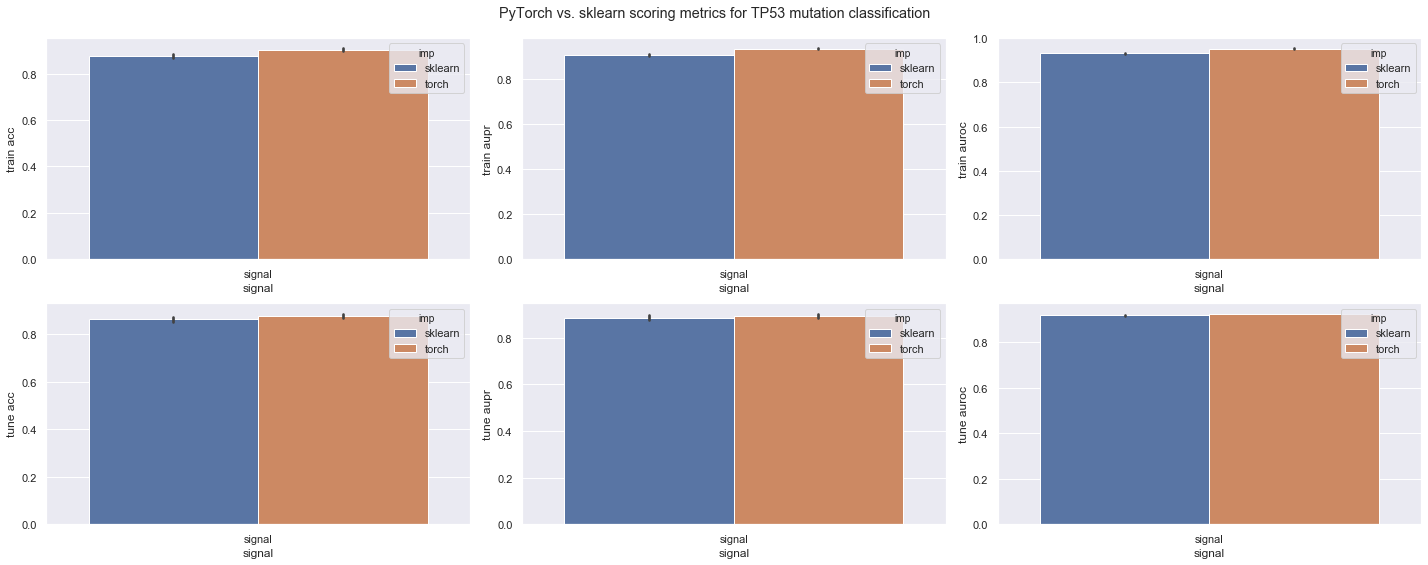

In [27]:
metrics = np.unique(results_df['metric'].values)
datasets = np.unique(results_df['dataset'].values)
sns.set()
fig, axarr = plt.subplots(len(datasets), len(metrics))
fig.set_figheight(8)
fig.set_figwidth(20)

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        ax = axarr[i, j]
        plot_df = results_df[(results_df['metric'] == metric) & (results_df['dataset'] == dataset)]
        sns.barplot(data=plot_df, x='signal', y='score', hue='imp', ax=ax)
        ax.set_ylabel('{} {}'.format(dataset, metric))
plt.tight_layout()
fig.suptitle('PyTorch vs. sklearn scoring metrics for TP53 mutation classification')
fig.subplots_adjust(top=0.925)

Results look fairly similar between implementations. Strangely, PyTorch seems to perform a bit worse on the shuffled data (control/baseline), but approximately the same on the untransformed data.

Next, compare coefficients (just sparsity for now).

In [28]:
columns = ['imp', 'signal', 'seed', 'fold', 'sparsity']
sparsity = []
for signal in signals:
    for seed in seeds:
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(
                                       signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(
                                          signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            sk_sparsity = np.count_nonzero(sk_coefs==0) / sk_coefs.shape[0]
            torch_sparsity = np.count_nonzero(torch_coefs==0) / torch_coefs.shape[0]
            sparsity.append(['sklearn', signal, seed, fold, sk_sparsity])
            sparsity.append(['torch', signal, seed, fold, torch_sparsity])
            
sparsity_df = pd.DataFrame(sparsity, columns=columns)
sparsity_df.head()

,imp,signal,seed,fold,sparsity
0,sklearn,signal,1,1,0.973323
1,torch,signal,1,1,0.000000
2,sklearn,signal,1,2,0.973199
3,torch,signal,1,2,0.000000
4,sklearn,signal,1,3,0.973822


Text(0.5, 1.0, 'Coefficient sparsity for PyTorch vs sklearn')

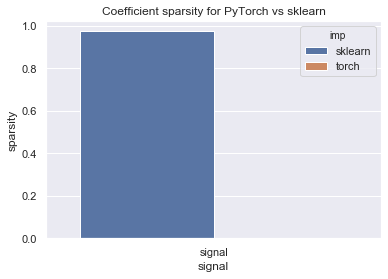

In [29]:
sns.set()
sns.barplot(data=sparsity_df, x='signal', y='sparsity', hue='imp')
plt.title('Coefficient sparsity for PyTorch vs sklearn')

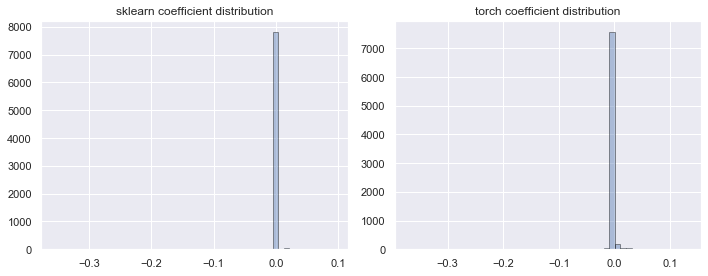

In [30]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
for i, coefs in enumerate([sk_coefs, torch_coefs]):
    ax = axarr[i]
    sns.distplot(coefs, kde=False, hist_kws={'edgecolor': 'black'}, ax=ax)
    ax.set_title('{} coefficient distribution'.format('sklearn' if i==0 else 'torch'))
plt.tight_layout()

So, coefficients for the PyTorch model don't appear to be sparse at all, but the coefficient distribution looks reasonably similar to the distribution of scikit-learn coefficients. Weird!

Why is this? I claim that my naive PyTorch implementation will almost never actually zero out the coefficients, although it shrinks many of them to almost zero.

It turns out that shrinking coefficients to exactly zero (and keeping them there) makes sense in theory, but numerically it's a fairly difficult problem. See, for instance, [this paper](https://www.aclweb.org/anthology/P09-1054.pdf) which contains a nice explanation of why it's hard to implement. Scikit-learn implements the algorithm in that paper, which is why it produces coefficients that are exactly 0.

Luckily, for our purposes there's not much difference between exactly 0 and almost 0.

Text(0.5, 1.0, 'Coefficient sparsity for PyTorch vs sklearn, with threshold')

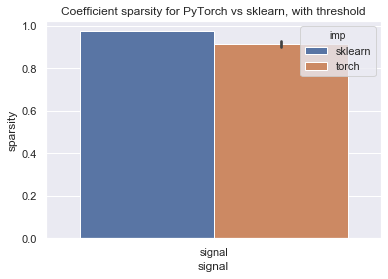

In [32]:
columns = ['imp', 'signal', 'seed', 'fold', 'sparsity']
sparsity = []
for signal in signals:
    for seed in seeds:
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(
                                       signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(
                                          signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            # pick a (somewhat arbitrary) threshold and set everything smaller to 0
            close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
            torch_coefs[close_to_zero] = 0
            sk_sparsity = np.count_nonzero(sk_coefs==0) / sk_coefs.shape[0]
            torch_sparsity = np.count_nonzero(torch_coefs==0) / torch_coefs.shape[0]
            sparsity.append(['sklearn', signal, seed, fold, sk_sparsity])
            sparsity.append(['torch', signal, seed, fold, torch_sparsity])
            
sparsity_df = pd.DataFrame(sparsity, columns=columns)
sns.set()
sns.barplot(data=sparsity_df, x='signal', y='sparsity', hue='imp')
plt.title('Coefficient sparsity for PyTorch vs sklearn, with threshold')

Great! This looks fairly similar. But how different are the nonzero coefficients that the methods are finding? Is there any similarity to the signal that the methods are using to predict mutation status?